# Calculation of detectable Gamma ray burst (GRB) event rate associated with Binary Neutron Star (BNS) mergers.

Analyst: [Hemanta Ph.](https://hemantaph.notion.site/Hemanta-Ph-b4c52e857d424c0db2a68f4e63d6097f), Anupreeta More, Otto Hannuksela.

Notes:

* This is without considering a particular detectors' sensitivity, but rather a general calculation of the rate of detectable GRBs based of viewing angle and luminosity distance. I have considered the inclination angle gravitational waves same as the viewing angle wrt GRB jet axis.

* It involves constructing Pdet (detection probability) function based off luminosity function.

* For BNS source redshift and mass distribution, refer [here](https://ler.readthedocs.io/en/latest/GW_events.html).

* For lens and image properties, refer [here](https://ler.readthedocs.io/en/latest/Lensed_events.html).

* Both SWIFT and FERMI detectors are considered.

* All analysis will be limited to redshift $z\in [0,5]$.

### Combined plot of viewing angle vs redshift for both conditions (left: Codition1, right: Condition2).

<p align="center">
  <img src="./combined final.png" alt="Your Logo" width="200%" style="margin: 0; padding: 0;">
</p>

## Equations (GRB)

* Ref: [Howell et. al. (2019)](https://arxiv.org/pdf/1811.09168)

* The luminosity function of GRBs is given by:

$$L(\theta_{V})=L_{c}\text{exp}(-\frac{\theta^{2}}{2\theta_{c}^{2}})$$

* Here, $L(\theta_{V})$ is the luminosity at viewing angle $\theta_{V}$, $L_{c}$ is the luminosity at the jet axis, $\theta$ is the viewing angle, and $\theta_{c}$ is the core angle of the jet.

* The paper gives: $\theta_{c} = 5$ degree.

* I will infer the probability of detection from the above equations.

$$P_{det}(\theta,D_L) = \left\{ 
  \begin{array}{ c l }
    1 & \text{if } \theta \le 5 \text{ deg and } D_L \le 46652 \text{ Mpc } (z\sim 5) \\
    1 & \text{if } \frac{\text{a}}{4\pi D_L^2} \text{exp}(-\frac{\theta^{2}}{2\times 21.2^2}) \ge 1 \\
    0 & \text{otherwise}
  \end{array}
\right.$$

* Coefficients a is solved by considering conditions 2 below,
  1. If angle <= 5 deg, distance <= distance_cut, then $P_{det}$ = 1.
  2. pdet=1, If angle=21.2 deg (at distance=40Mpc). This is by considering the GRB from GW170817 would have been difficult to detect if viewing angle>21.2 deg (at distance=40Mpc) or distance>40 Mpc (at angle=21.2 deg).

In [1]:
# calling the necessary libraries
from ler.rates import LeR
import numpy as np
# interpolate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from ler.utils import get_param_from_json

## Probability of detection of GRBs

### Finding the coefficients

In [2]:
import numpy as np
from scipy.optimize import fsolve

# to find coefficient a
# consider: pdet = 1, If angle = 21.2 deg (at distance=40). 
def equation(a):
    angle = 21.2
    distance = 40
    return a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2) - 1

a_guess = 10000

# Solve the equation
a_solution = fsolve(equation, a_guess)

print(f"a = {a_solution[0]}")

a = 161107621.34601912


### Function to calculate the probability of detection

In [3]:
# Find distance_cut
# convert redshift to luminoisty distance
import astropy.units as u
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
# let's assume z = 5 is the distance cut
z = 5
d_L = cosmo.luminosity_distance(z)
print(f"d_L = {d_L}")

d_L = 46652.22297277719 Mpc


In [4]:
class GRB:
    def __init__(self,
    z_min = 0, # minimum redshift
    z_max = 10, # maximum redshift 
    core_angle = 5, # core angle in degrees
    distance_cut = 46652.22297277721, # distance cut in Mpc for z=5
    cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7), # cosmology
    ):
        self.core_angle = core_angle
        self.distance_cut = distance_cut
        self.cosmo = cosmo
        self.coefficient = self.coefficient_finder()

        # interpolate and find luminosity distance to redshift conversion
        z = np.geomspace(z_min+0.0001, z_max, 10000)
        d_L = cosmo.luminosity_distance(z).value
        self.z_to_dl = interp1d(z, d_L, kind='cubic', fill_value='extrapolate')
        self.dl_to_z = interp1d(d_L, z, kind='cubic', fill_value='extrapolate')

    def coefficient_finder(self, a_guess = 10000):
        """
        Function to find the coefficient 'a' in the GRB pdet model.
        pdet = a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2){2\times 21.2^2})
        pdet = 1, If angle = 21.2 deg (at distance=40).

        Parameters
        ----------
        a_guess : float
            Initial guess for the coefficient 'a'
            default is 10000

        Returns
        -------
        float
            Coefficient 'a' in the GRB pdet model
        """
        def equation(a):
            # wrt to GW170817
            angle = 21.2
            distance = 40
            return a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/5)**2) - 1

        a_solution = fsolve(equation, a_guess)
        return a_solution[0]
    
    def pdet_grb(self, angle, distance, distance_cut=None, duty_cycle=0.5, mask_duty_cycle=True, bool=True, pdet_cut=1.):
        """
        Function to calculate the probability of detection for a given angle and distance (Mpc) for GRB. 

        Parameters
        ----------
        angle : numpy.ndarray
            Angle between the GRB jet and viewing angle in (rad)
        distance : numpy.ndarray
            Distance between the GRB source and the satellite in (Mpc)
        distance_cut : float
            Core angular size of the GRB jet in (rad)
            default is 25422.742 Mpc
        duty_cycle : float
            Duty cycle of detector(s)
            default is 0.5 (50%: for Fermi-GBM and Swift-BAT combined)
        bool : bool
            if True, return absolute value of pdet
            if False, return the pdet value as boolean (with duty cycle applied)

        Returns
        -------
        numpy.ndarray
            Probability of detection for a given angle and distance
        """

        a = self.coefficient
        jet_angle_cut = self.core_angle
        if distance_cut is None:
            distance_cut = self.distance_cut

        # make sure that the input data is a numpy array
        angle, distance = np.array([angle]).reshape(-1), np.array([distance]).reshape(-1)

        # angle should be less than 90 or equal to 90
        if len(angle[angle > 90]) > 0:
            angle[angle > 90] = angle[angle > 90]%90

        if bool:
            # calculate the probability of detection, absolute value
            pdet = abs(a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/jet_angle_cut)**2))

            # find idx of angle <= jet_angle_cut and distance <= distance_cut
            idx = (angle <= jet_angle_cut) & (distance <= distance_cut)
            # apply the condition, condition 1 from docstring
            pdet[idx] = 1

            # apply the duty cycle
            if mask_duty_cycle:
                # sample random numbers from 0 to 1 and check if it is less than the duty cycle
                num_ = np.random.rand(len(angle))
                mask_duty_cycle = num_ > duty_cycle
                pdet[mask_duty_cycle] = 0

            # return the pdet as boolean
            return (pdet>=pdet_cut).astype(int)
        else:
            # return the probability of detection (absolute value)
            return abs(a/(4*np.pi*distance**2) * np.exp(-0.5*(angle/jet_angle_cut)**2))
    
    def pdet_calculator(self, gw_param_dict, duty_cycle=0.6, mask_duty_cycle=True, bool=True, pdet_cut=1.):
        """
        Pdet calculator for GRB. The  inputs and outputs are are compatible with ler package.

        Parameters
        ----------
        gw_param_dict : dict
            dictionary containing the parameters for the GW event
        duty_cycle : float
            Duty cycle of detector(s)
            default is 0.5 (50%: for Fermi-GBM and Swift-BAT combined)
        mask_duty_cycle : bool
            if True, apply the duty cycle
            default is True
        bool : bool
            if True, return absolute value of pdet
            if False, return the pdet value as boolean (with duty cycle applied)

        Returns
        -------
        dict
            dictionary containing the probability of detection for the given GW event
        """

        # get the angle and distance from the dictionary
        angle = np.degrees(gw_param_dict['theta_jn'])
        if 'luminosity_distance' in gw_param_dict:
            distance = gw_param_dict['luminosity_distance']
        elif 'effective_luminosity_distance' in gw_param_dict:
            distance = gw_param_dict['effective_luminosity_distance']

        # calculate the probability of detection
        pdet = self.pdet_grb(angle, distance, duty_cycle=duty_cycle, mask_duty_cycle=mask_duty_cycle, bool=bool, pdet_cut=pdet_cut)
        pdet_net_dict = dict(pdet_net=pdet)

        # return the pdet
        return pdet_net_dict

In [5]:
# class initialization
grb = GRB()

In [6]:
# test the pdet_grb function
angle = np.array([1, 1, 20, 90])
distance = np.array([46652, 46653, 40, 40])
print(grb.pdet_grb(angle, distance, mask_duty_cycle=False, bool=True))

[1 0 1 0]


In [7]:
# test the pdet_calculator function
gw_param_dict = {'theta_jn': np.radians(np.array([1, 21.2, 90])), 'luminosity_distance': np.array([2500, 40, 40])}
print(grb.pdet_calculator(gw_param_dict, mask_duty_cycle=False, bool=True))

{'pdet_net': array([1, 1, 0])}


### Plot detection and non-detection regions

In [8]:
# generate random data
angle = np.random.uniform(0, 30, 5000)
log10_distance = np.random.uniform(0, 5, 5000)
distance = 10**log10_distance
redshift = grb.dl_to_z(distance)

pdet = grb.pdet_grb(angle, distance, mask_duty_cycle=False, bool=True)

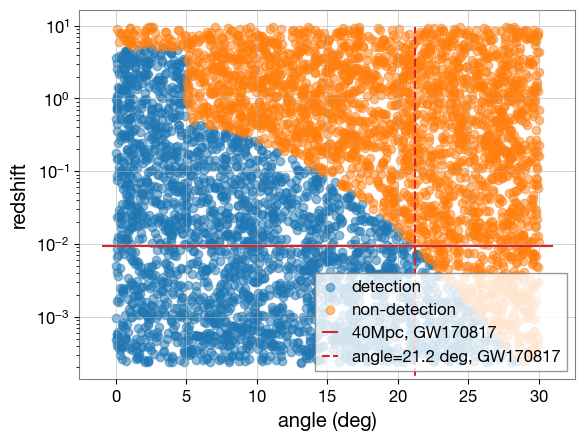

In [10]:
# blue: detection, red: non-detection
plt.scatter(angle[pdet==1], redshift[pdet==1], c='C0', label="detection", alpha=0.5)
plt.scatter(angle[pdet==0], redshift[pdet==0], c='C1', label="non-detection", alpha=0.5)

# draw a horizontal line for GW170817, 40Mpc
plt.hlines(y=grb.dl_to_z(40), xmin=min(angle)-1, xmax=max(angle)+1, colors='C3', linestyles='solid', label='40Mpc, GW170817')
# draw a vertical line for the angle=21.2 deg for GW170817
plt.vlines(x=21.2, ymin=min(redshift)-0.1, ymax=max(redshift)+0.1, colors='C3', linestyles='dashed', label='angle=21.2 deg, GW170817')

plt.xlabel("angle (deg)")
plt.ylabel("redshift")
plt.yscale("log")
plt.legend()
plt.grid(alpha=0.8)
plt.show()

## Rate calculation of GRB with LeR

All the necessary functions and parameters are defined below.

**Source related:**
* source frame mass: m1 and m2 sample from [double Gaussian](https://ler.readthedocs.io/en/latest/GW_events.html#BNS-mass-distribution:-Bimodal-Gaussian-Model) model lim[1,2.3]Mo
* Geocent time period: uniform prior, 1 year GPS: {'min_': 1238166018, 'max_': 1269702018}
* Redshift: 0 to 5, uniform, 
  * this follows [merger rate density distribution](https://ler.readthedocs.io/en/latest/GW_events.html#Merger-Rate-Density-Formula)
* ra:  sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* dec:  sampler_cosine [-np.pi/2, np.pi/2]
* phase : sampler_uniform {'min_': 0.0, 'max_': 6.283185307179586}
* psi: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}
* theta_jn: sampler_uniform {'min_': 0.0, 'max_': 3.141592653589793}

**Lens related**
* Optical depth: SIE , 
  * so zs for lensed are rejection sampled with optical depth. 
* Lens redshifts: SDSS catalogue (0 to zs), the function of zs Reenske et al. 2021 ( eqnC13). [`ler` function](https://github.com/hemantaph/ler/blob/bce3330638a13ee0883d19633abb17b98791c901/ler/lens_galaxy_population/jit_functions.py#L218)
* Velocity dispersion: gengamma, Haris et al 2018, a=2.32 / 2.67, c=2.67, vd_min=0., vd_max=600.(https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gengamma.html) use in Haris et al upto zs~1.5 (with a=2.32 / 2.67, c=2.67)
* Axis ratio: Raleigh (with Velocity dispersion dependence) {'q_min': 0.2, 'q_max': 1.0}
* axis_rotation_angle : uniform {'phi_min': 0.0, 'phi_max': 6.283185307179586}
* shear: normal {'scale': 0.05}
* density_profile_slope: normal {'mean': 2.0, 'std': 0.2}

**Image related:**
* Strong lensing condition: num_images>=2
* Lens equation solver: EPL+Shear, `lenstronomy`
* Source position: sample within caustic,  Ewoud et. al. 2022

## MEDIAN

In [15]:
ler = LeR(
    npool=4,
    verbose=False,
    z_max=10,
    pdet_finder=grb.pdet_calculator,
    source_priors= {'merger_rate_density': 'sfr_madau_dickinson2014'},
    source_priors_params= {'merger_rate_density': dict(a=105.6 * 1e-9, b=2.6, c=3.2, d=6.2)}, # sfr_madau_fragos2017
    event_type='BBH',
    mtot_min=2.0,
    mtot_max=51,
    # psds={'L1':'../rates_o4/o4_psd.txt', 'H1':'../rates_o4/o4_psd.txt'},
    snr_type="interpolation",
)


Initializing LeR class...



### Unlensed events

In [20]:
unlensed_param_detectable = ler.selecting_n_unlensed_detectable_events(
    size=200000,
    stopping_criteria=None,
    batch_size=200000,
    resume=False,
    trim_to_size=False,
    detectability_condition="pdet",
    output_jsonfile="n_unlensed_params_detectable_grb_median.json",
    meta_data_file="meta_unlensed_grb_median.json",
)
# time: 3 min 30 s

removing ./ler_data/n_unlensed_params_detectable_grb_median.json and ./ler_data/meta_unlensed_grb_median.json if they exist
collected number of detectable events =  0
collected number of detectable events =  5189
total number of events =  200000
total rate (yr^-1): 12211.640807546972
collected number of detectable events =  10329
total number of events =  400000
total rate (yr^-1): 12153.98322423903
collected number of detectable events =  15607
total number of events =  600000
total rate (yr^-1): 12243.019084177142
collected number of detectable events =  20817
total number of events =  800000
total rate (yr^-1): 12247.529711442729
collected number of detectable events =  25828
total number of events =  1000000
total rate (yr^-1): 12156.571932061019
collected number of detectable events =  30958
total number of events =  1200000
total rate (yr^-1): 12142.608598960593
collected number of detectable events =  36030
total number of events =  1400000
total rate (yr^-1): 12113.135431982966

SystemError: CPUDispatcher(<function sample_powerlaw_gaussian_source_bbh_masses at 0x316c783a0>) returned a result with an exception set

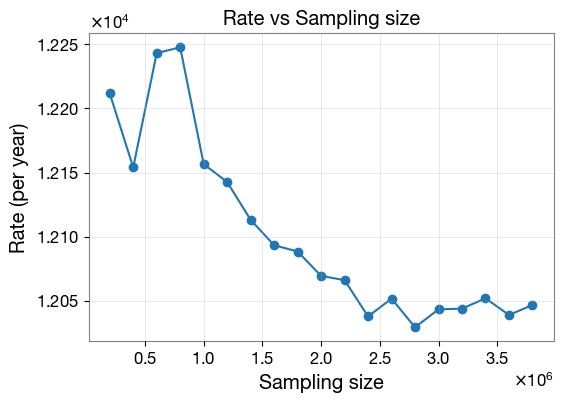

In [21]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_unlensed_grb_median.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [22]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 3e6)[0]
# take average 
grb_rate_unlensed_median = np.mean(meta_data['total_rate'][idx])
print('Unlensed GRB Rate (per year) =', grb_rate_unlensed_median)

Unlensed GRB Rate (per year) = 12045.457829739751


### Lensed events

In [65]:
lensed_param_detectable = ler.selecting_n_lensed_detectable_events(
    size=20000,
    batch_size=50000,
    # snr_threshold=[8.0,8.0],
    # num_img=[1,1],
    resume=True,
    trim_to_size=False,
    detectability_condition="pdet",
    output_jsonfile="n_lensed_params_detectable_grb_median.json",
    meta_data_file="meta_lensed_grb_median.json",
)

  0%|                                                           | 87/50000 [00:00<00:57, 864.14it/s]

collected number of detectable events =  10000


  0%|                                                           | 85/50000 [00:00<00:59, 845.99it/s]

collected number of detectable events =  10495
total number of events =  1148064.0
total rate (yr^-1): 5.149914543656013
percentage difference for the last 4 batches = [0.06719499 0.30455967 0.37782882 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 87/50000 [00:00<00:57, 868.13it/s]

collected number of detectable events =  10969
total number of events =  1198064.0
total rate (yr^-1): 5.157873618200011
percentage difference for the last 4 batches = [0.45839893 0.53155502 0.15430922 0.        ]


  0%|                                                           | 83/50000 [00:00<01:00, 826.93it/s]

collected number of detectable events =  11432
total number of events =  1248064.0
total rate (yr^-1): 5.160229747527054
percentage difference for the last 4 batches = [0.5769717  0.19989815 0.04565939 0.        ]


  0%|                                                           | 86/50000 [00:00<00:58, 854.46it/s]

collected number of detectable events =  11889
total number of events =  1298064.0
total rate (yr^-1): 5.15980037875505
percentage difference for the last 4 batches = [0.19159336 0.03734177 0.00832142 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 87/50000 [00:00<00:57, 863.28it/s]

collected number of detectable events =  12328
total number of events =  1348064.0
total rate (yr^-1): 5.151880646960212
percentage difference for the last 4 batches = [0.11632589 0.16205928 0.15372506 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 81/50000 [00:00<01:01, 805.16it/s]

collected number of detectable events =  12781
total number of events =  1398064.0
total rate (yr^-1): 5.150168764648806
percentage difference for the last 4 batches = [0.19535249 0.1870155  0.03323934 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 86/50000 [00:00<00:58, 849.94it/s]

collected number of detectable events =  13169
total number of events =  1448064.0
total rate (yr^-1): 5.123287404068933
percentage difference for the last 4 batches = [0.71268644 0.55810343 0.52468969 0.        ]


  0%|                                                           | 87/50000 [00:00<00:58, 860.52it/s]

collected number of detectable events =  13649
total number of events =  1498064.0
total rate (yr^-1): 5.132797665002759
percentage difference for the last 4 batches = [0.3717852  0.33843336 0.18528416 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 86/50000 [00:00<00:58, 858.15it/s]

collected number of detectable events =  14098
total number of events =  1548064.0
total rate (yr^-1): 5.130412363201004
percentage difference for the last 4 batches = [0.38508408 0.13887693 0.04649337 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 80/50000 [00:00<01:02, 793.16it/s]

collected number of detectable events =  14509
total number of events =  1598064.0
total rate (yr^-1): 5.114780386042382
percentage difference for the last 4 batches = [0.16632225 0.35225909 0.30562362 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 87/50000 [00:00<00:57, 866.73it/s]

collected number of detectable events =  14948
total number of events =  1648064.0
total rate (yr^-1): 5.109668141805117
percentage difference for the last 4 batches = [0.45266195 0.40597982 0.10005042 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


  0%|                                                           | 82/50000 [00:00<01:01, 816.02it/s]

collected number of detectable events =  15392
total number of events =  1698064.0
total rate (yr^-1): 5.106515782069757
percentage difference for the last 4 batches = [0.46796254 0.16184429 0.06173211 0.        ]
stopping criteria of rate relative difference of 0.5% reached. If you want to collect more events, reduce stopping_criteria['relative_diff_percentage']


 41%|██████████████████████▊                                 | 20363/50000 [00:24<00:35, 831.23it/s]


KeyboardInterrupt: 

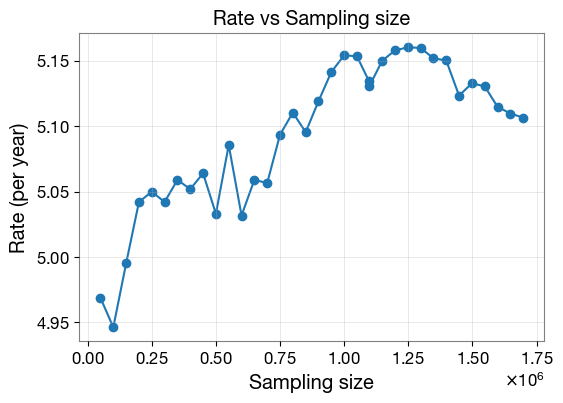

In [66]:
# getting data from json
meta_data= get_param_from_json("ler_data/meta_lensed_grb_median.json")

# plot the rate vs sampling size
plt.figure(figsize=(6,4))
plt.plot(meta_data['events_total'], meta_data['total_rate'], 'o-')
plt.xlabel('Sampling size')
plt.ylabel('Rate (per year)')
plt.title('Rate vs Sampling size')
plt.grid(alpha=0.4)
plt.show()

In [67]:
# select only events after sampling size of 
idx = np.where(meta_data['events_total'] > 0.5e6)[0]
# take average 
grb_rate_lensed_median = np.mean(meta_data['total_rate'][idx])
print('Lensed GRB Rate (per year) =', grb_rate_lensed_median)

Lensed GRB Rate (per year) = 5.120478963373704


In [27]:
grb_rate_unlensed_median/grb_rate_lensed_median, grb_rate_unlensed_median, grb_rate_lensed_median

(2360.5358178457086, 12045.457829739751, 5.102848996687868)

In [1]:
from ler.utils import get_param_from_json
import numpy as np

lens_param_n = get_param_from_json('ler_data/n_lensed_params_detectable_grb_median.json')

In [2]:
# 3 images
# add accross all images
snr = lens_param_n['pdet_net']==1.

# add accross all images
num_ = np.sum(snr, axis=1)
# select only 3 images detectable events, for 3 image and 4 image events
idx = num_ == 3

# get time information
dt_eff = lens_param_n['effective_geocent_time'][idx]
snr = lens_param_n['pdet_net'][idx]
mu = lens_param_n['magnifications'][idx]

dt_3images_10 = []
dt_3images_21 = []
for i, dt in enumerate(dt_eff):
    # detected images
    ii = np.where(snr[i] == 1)[0]
    ii = np.sort(ii)

    # image 1,0
    dt_3images_10.append(abs(dt[ii[1]]-dt[ii[0]]))
    # image 2,1
    dt_3images_21.append(abs(dt[ii[2]]-dt[ii[1]]))
        
dt_3images_10 = np.array(dt_3images_10)
dt_3images_21 = np.array(dt_3images_21)

In [3]:
# number of 3 images events and 4 images events
mu = ~np.isnan(lens_param_n['magnifications'])[idx]
num_3img, num_4img, num_detected, total_events = np.sum(np.sum(mu, axis=1)==3), np.sum(np.sum(mu, axis=1)==4), np.sum(idx), len(idx)

# percentage of 3 images events
perc_3img = num_3img/total_events * 100
# percentage of 4 images events
perc_4img = num_4img/total_events * 100

# print the results
print(f"Number of 3 images events: {num_3img}, Percentage: {perc_3img:.2f}%")
print(f"Number of 4 images events: {num_4img}, Percentage: {perc_4img:.2f}%")
print(f"Total number of detected events: {num_detected}, Total events: {total_events}")

Number of 3 images events: 94, Percentage: 0.61%
Number of 4 images events: 1412, Percentage: 9.17%
Total number of detected events: 1506, Total events: 15392


In [4]:
dt_3images_10

array([4.07031117e+03, 3.08704095e+05, 4.90379357e+04, ...,
       3.79936530e+04, 5.75527442e+06, 2.50009433e+05])

In [5]:
unlensed_params_detectable = get_param_from_json("ler_data/n_unlensed_params_detectable_grb_median.json")

In [6]:
# simulating time delay difference and magnification ratio, for unlensed population
size = 10000

t = unlensed_params_detectable["geocent_time"]
mu = unlensed_params_detectable["luminosity_distance"]

len_ = len(t)
t_ = []
mu_ = []
idx1 = np.random.choice(np.arange(0,len_), size, replace=False)
idx2 = np.random.choice(np.arange(0,len_), size, replace=False)
t_.append(t[idx2] - t[idx1])
mu_.append(mu[idx2] / mu[idx1])

dt_ul = np.abs(np.array(t_).flatten())
dmu_ul = np.abs(np.array(mu_).flatten())**2

In [7]:
dt_10 = 13*60*60 + 56*60 + 5.77 - (13*60*60 + 9*60 + 2.03)
dt_21 = 16*60*60 + 21*60 + 33.07 - (13*60*60 + 56*60 + 5.77)
print(f"dt_10 = {dt_10/60} mins")
print(f"dt_21 = {dt_21/60} mins")

dt_10 = 47.0623333333333 mins
dt_21 = 145.45500000000004 mins


dt_10 = 47.0623333333333 mins
dt_21 = 145.45500000000004 mins


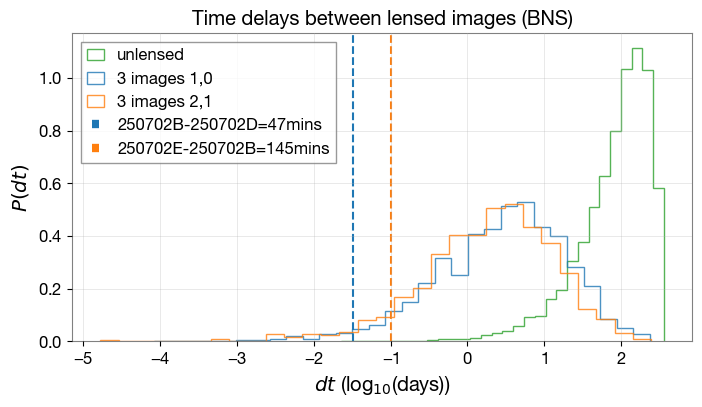

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# events

dt_10 = 13*60*60 + 56*60 + 5.77 - (13*60*60 + 9*60 + 2.03)
dt_21 = 16*60*60 + 21*60 + 33.07 - (13*60*60 + 56*60 + 5.77)
print(f"dt_10 = {dt_10/60} mins")
print(f"dt_21 = {dt_21/60} mins")

# plot histogram
plt.figure(figsize=(8, 4))

# unlensed events
plt.hist(np.log10(dt_ul/(24*60*60)), bins=30, alpha=0.8, density=True, histtype='step', color='C2', label='unlensed')

# lensed events
plt.hist(np.log10(dt_3images_10/(24*60*60)), bins=30, alpha=0.8, density=True, histtype='step', color='C0', label='3 images 1,0')
plt.hist(np.log10(dt_3images_21/(24*60*60)), bins=30, alpha=0.8, density=True, histtype='step', color='C1', label='3 images 2,1') 

plt.axvline(np.log10(dt_10/(24*60*60)), color='C0', linestyle='--', label='250702B-250702D=47mins')
plt.axvline(np.log10(dt_21/(24*60*60)), color='C1', linestyle='--', label='250702E-250702B=145mins')

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'$dt$ (log$_{10}$(days))')
plt.ylabel(r'$P(dt)$')
plt.title('Time delays between lensed images (BNS)')
plt.show()

dt_10 = 0.7843722222222217 hrs
dt_21 = 2.4242500000000007 hrs


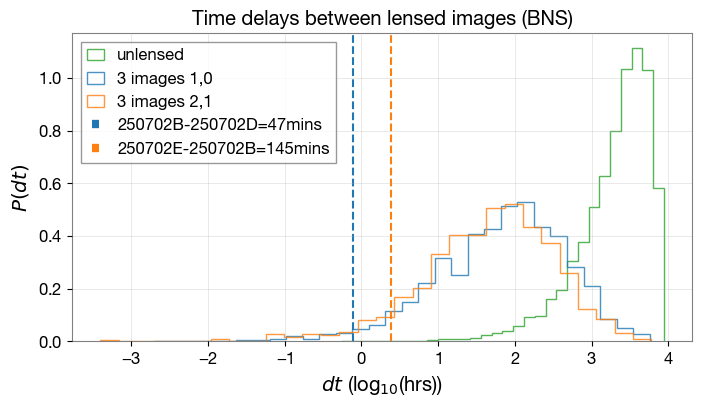

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# events

dt_10 = 13*60*60 + 56*60 + 5.77 - (13*60*60 + 9*60 + 2.03)
dt_21 = 16*60*60 + 21*60 + 33.07 - (13*60*60 + 56*60 + 5.77)
print(f"dt_10 = {dt_10/3600} hrs")
print(f"dt_21 = {dt_21/3600} hrs")

# plot histogram
plt.figure(figsize=(8, 4))

# unlensed events
plt.hist(np.log10(dt_ul/(3600)), bins=30, alpha=0.8, density=True, histtype='step', color='C2', label='unlensed')

# lensed events
plt.hist(np.log10(dt_3images_10/(3600)), bins=30, alpha=0.8, density=True, histtype='step', color='C0', label='3 images 1,0')
plt.hist(np.log10(dt_3images_21/(3600)), bins=30, alpha=0.8, density=True, histtype='step', color='C1', label='3 images 2,1') 

plt.axvline(np.log10(dt_10/(3600)), color='C0', linestyle='--', label='250702B-250702D=47mins')
plt.axvline(np.log10(dt_21/(3600)), color='C1', linestyle='--', label='250702E-250702B=145mins')

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'$dt$ (log$_{10}$(hrs))')
plt.ylabel(r'$P(dt)$')
plt.title('Time delays between lensed images (BNS)')
plt.show()

In [38]:
np.log10(dt_10/(24*60*60)), np.log10(dt_21/(24*60*60)), np.log10(np.exp(1))/0.1

(-1.485689036559331, -0.9956338374294144, 4.3429448190325175)

In [39]:
np.log10(np.exp(1))/0.1

4.3429448190325175

dt_10 = 47.0623333333333 mins
dt_21 = 145.45500000000004 mins


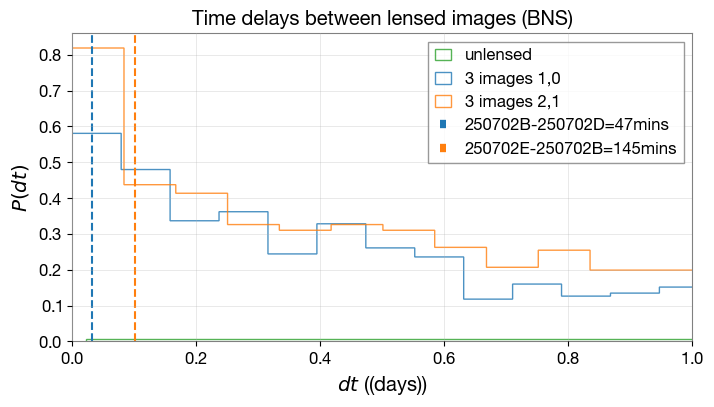

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# events

dt_10 = 13*60*60 + 56*60 + 5.77 - (13*60*60 + 9*60 + 2.03)
dt_21 = 16*60*60 + 21*60 + 33.07 - (13*60*60 + 56*60 + 5.77)
print(f"dt_10 = {dt_10/(24*60*60)} mins")
print(f"dt_21 = {dt_21/(24*60*60)} mins")

# plot histogram
plt.figure(figsize=(8, 4))

# unlensed events
plt.hist(dt_ul/(24*60*60), bins=30, alpha=0.8, density=True, histtype='step', color='C2', label='unlensed')

# lensed events
plt.hist(dt_3images_10/(24*60*60), bins=3000, alpha=0.8, density=True, histtype='step', color='C0', label='3 images 1,0')
plt.hist(dt_3images_21/(24*60*60), bins=3000, alpha=0.8, density=True, histtype='step', color='C1', label='3 images 2,1') 

plt.axvline(dt_10/(24*60*60), color='C0', linestyle='--', label='250702B-250702D=47mins')
plt.axvline(dt_21/(24*60*60), color='C1', linestyle='--', label='250702E-250702B=145mins')
# plt.xscale('log')
plt.xlim(0, 1)
plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'$dt$ ((days))')
plt.ylabel(r'$P(dt)$')
plt.title('Time delays between lensed images (BNS)')
plt.show()

In [ ]:
2000/

/var/folders/ws/0948zvwd7g795j2l3fryghjw0000gp/T/ipykernel_67943/2376234328.py:40: UserWarning: The following kwargs were not used by contour: 'labels'
  plt.contour(X, Y, Z, levels=contour_values, colors=['w', 'orange', 'red'], linewidths=1.5,


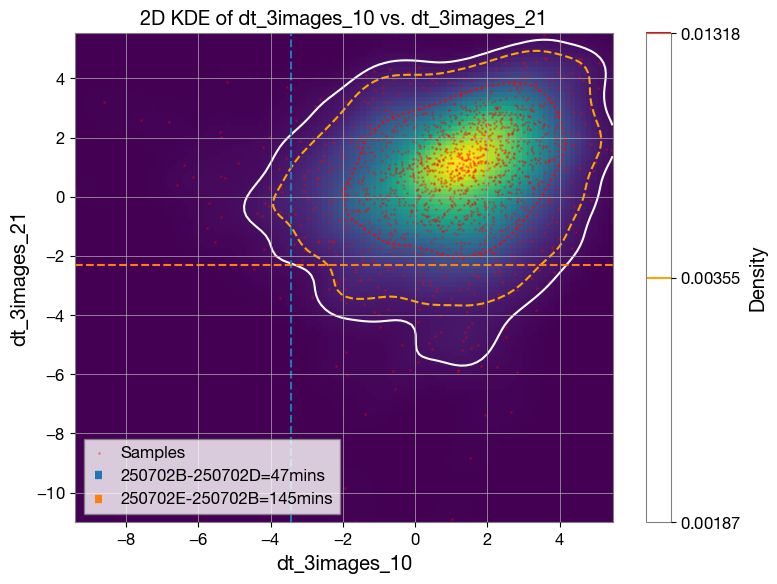

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Example data (replace with your actual arrays)
# dt_3images_10 = np.array([...])
# dt_3images_21 = np.array([...])

# 1. Stack the two distributions as a 2D array (shape: 2 x N)
values = np.vstack([np.log(dt_3images_10/(24*60*60)), np.log(dt_3images_21/(24*60*60))])

# 2. Create the 2D Gaussian KDE
kde = gaussian_kde(values)

# 3. Create a regular grid to evaluate KDE
xmin, xmax = np.log(dt_3images_10.min()/(24*60*60)), np.log(dt_3images_10.max()/(24*60*60))
ymin, ymax = np.log(dt_3images_21.min()/(24*60*60)), np.log(dt_3images_21.max()/(24*60*60))

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])

# 4. Evaluate the KDE on the grid
Z = np.reshape(kde(positions).T, X.shape)

# 5. Plot the results
plt.figure(figsize=(8, 6))
plt.imshow(np.rot90(Z), 
           extent=[xmin, xmax, ymin, ymax],
           aspect='auto',
           cmap='viridis')

# Add contour levels for 68%, 90%, 95%
levels = [0.68, 0.90, 0.95]
Z_flat = Z.flatten()
Z_sorted = np.sort(Z_flat)[::-1]
Z_cumsum = np.cumsum(Z_sorted) / np.sum(Z_sorted)
contour_values = [Z_sorted[np.searchsorted(Z_cumsum, lvl)] for lvl in levels]
contour_values = np.sort(contour_values)  # Ensure increasing order

plt.contour(X, Y, Z, levels=contour_values, colors=['w', 'orange', 'red'], linewidths=1.5,
            linestyles=['solid', 'dashed', 'dotted'],
            labels=['68%', '90%', '95%'])
plt.colorbar(label='Density')
plt.scatter(np.log(dt_3images_10/(24*60*60)), np.log(dt_3images_21/(24*60*60)), c='r', s=1, alpha=0.3, label='Samples')

# plot np.log(dt_10/(24*60*60)), 
plt.axvline(np.log(dt_10/(24*60*60)), color='C0', linestyle='--', label='250702B-250702D=47mins')
plt.axhline(np.log(dt_21/(24*60*60)), color='C1', linestyle='--', label='250702E-250702B=145mins')


plt.xlabel('dt_3images_10')
plt.ylabel('dt_3images_21')
plt.title('2D KDE of dt_3images_10 vs. dt_3images_21')
plt.legend()
plt.tight_layout()
plt.show()


In [55]:
0.002/(1/12)**2

0.28800000000000003

In [ ]:
# find probability of using kde
dt_10 = np.log((13*60*60 + 56*60 + 5.77 - (13*60*60 + 9*60 + 2.03))/(24*60*60))
dt_21 = np.log((16*60*60 + 21*60 + 33.07 - (13*60*60 + 56*60 + 5.77))/(24*60*60))

kde([dt_10, dt_21])

array([0.00254092])

In [102]:
# simulating time delay difference and magnification ratio, for unlensed population
size = 20000

t = unlensed_params_detectable["geocent_time"]
mu = unlensed_params_detectable["luminosity_distance"]

len_ = len(t)
t_ = []
mu_ = []
idx1 = np.random.choice(np.arange(0,len_), size, replace=False)
idx2 = np.random.choice(np.arange(0,len_), size, replace=False)
t_.append(t[idx2] - t[idx1])
mu_.append(mu[idx2] / mu[idx1])

dt_ul_10 = np.abs(np.array(t_).flatten())


t_ = []
mu_ = []
idx1 = np.random.choice(np.arange(0,len_), size, replace=False)
idx2 = np.random.choice(np.arange(0,len_), size, replace=False)
t_.append(t[idx2] - t[idx1])
mu_.append(mu[idx2] / mu[idx1])

dt_ul_21 = np.abs(np.array(t_).flatten())

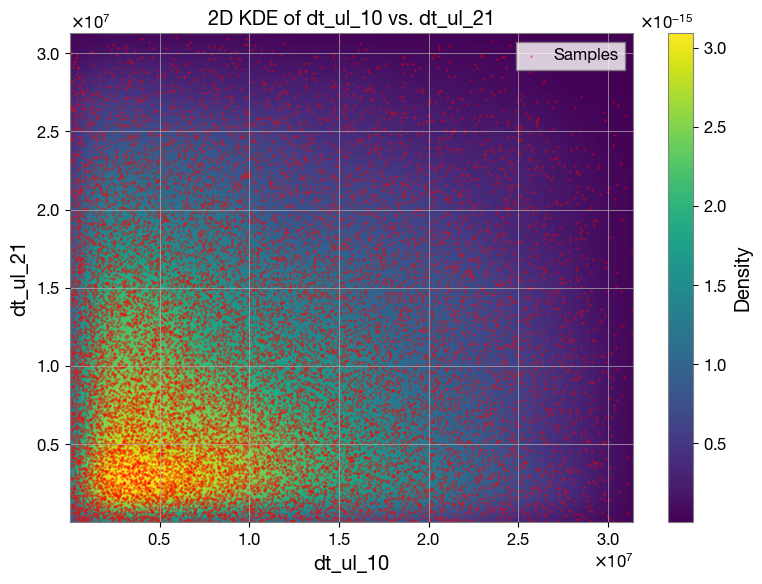

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 1. Stack the two distributions as a 2D array (shape: 2 x N)
values = np.vstack([dt_ul_10, dt_ul_21])

# 2. Create the 2D Gaussian KDE
kde = gaussian_kde(values)

# 3. Create a regular grid to evaluate KDE
xmin, xmax = dt_ul_10.min(), dt_ul_10.max()
ymin, ymax = dt_ul_21.min(), dt_ul_21.max()

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])

# 4. Evaluate the KDE on the grid
Z = np.reshape(kde(positions).T, X.shape)

# 5. Plot the results
plt.figure(figsize=(8, 6))
plt.imshow(np.rot90(Z), 
           extent=[xmin, xmax, ymin, ymax],
           aspect='auto',
           cmap='viridis')
plt.colorbar(label='Density')
plt.scatter(dt_ul_10, dt_ul_21, c='r', s=1, alpha=0.3, label='Samples')
plt.xlabel('dt_ul_10')
plt.ylabel('dt_ul_21')
plt.title('2D KDE of dt_ul_10 vs. dt_ul_21')
plt.legend()
plt.tight_layout()
plt.show()

In [104]:
kde([dt_10, dt_21])

array([9.06043826e-16])

In [105]:
# find probability of using kde
dt_10 = 13*60*60 + 56*60 + 5.77 - (13*60*60 + 9*60 + 2.03)
dt_21 = 16*60*60 + 21*60 + 33.07 - (13*60*60 + 56*60 + 5.77)

kde([dt_10, dt_21])

array([9.06043826e-16])

In [ ]:
# RLU
3.40379951e-13/9.06043826e-16

375.6771374986445

In [107]:
# BLU*RLU
BF = 1390.3137*375.6771374986445
print(f"Bayes Factor: {BF:.4f}")
print(f"log10 BF: {np.log10(BF):.4f}") 

Bayes Factor: 522309.0710
log10 BF: 5.7179


In [55]:
# 4 images
# add accross all images
snr = lens_param_n['pdet_net']==1.
mu = ~np.isnan(lens_param_n['magnifications'])
type = lens_param_n['image_type']

# add accross all images
num_ = np.sum(mu, axis=1)
# select only 4 images
idx = num_ == 4
# get time information
dt_eff = lens_param_n['effective_geocent_time'][idx]
snr = lens_param_n['pdet_net'][idx]

dt_4images_10 = []
dt_4images_20 = []
dt_4images_30 = []
dt_4images_21 = []
dt_4images_31 = []
dt_4images_32 = []
dt_4images = []
for i, dt in enumerate(dt_eff):
    # image 1,0
    if snr[i, 1] == 1. and snr[i, 0] == 1.:
        dt_4images_10.append(abs(dt[1]-dt[0]))
    # image 2,0
    if snr[i, 2] == 1. and snr[i, 0] == 1.:
        dt_4images_20.append(abs(dt[2]-dt[0]))
    # image 3,0
    if snr[i, 3] == 1. and snr[i, 0] == 1.:
        dt_4images_30.append(abs(dt[3]-dt[0]))
    # image 2,1
    if snr[i, 2] == 1. and snr[i, 1]== 1.:
        dt_4images_21.append(abs(dt[2]-dt[1]))
    # image 3,1
    if snr[i, 3] == 1. and snr[i, 1]== 1.:
        dt_4images_31.append(abs(dt[3]-dt[1]))
    # image 3,2
    if snr[i, 3] == 1. and snr[i, 2]== 1.:
        dt_4images_32.append(abs(dt[3]-dt[2]))

dt_4images_10 = np.array(dt_4images_10)/(60)
dt_4images_20 = np.array(dt_4images_20)/(60)
dt_4images_30 = np.array(dt_4images_30)/(60)
dt_4images_21 = np.array(dt_4images_21)/(60)
dt_4images_31 = np.array(dt_4images_31)/(60)
dt_4images_32 = np.array(dt_4images_32)/(60)
dt_4images = np.concatenate([dt_4images_10, dt_4images_20, dt_4images_30, dt_4images_21, dt_4images_31, dt_4images_32])

In [57]:
# 1,0: 13:56:05.77-13:09:02.03
# 2,1: 14:49:31.91-13:56:05.77
# 3,2: 16:21:33.07-14:49:31.91

dt_10 = 13*60*60 + 56*60 + 5.77 - (13*60*60 + 9*60 + 2.03)
dt_21 = 14*60*60 + 49*60 + 31.91 - (13*60*60 + 56*60 + 5.77)
dt_32 = 16*60*60 + 21*60 + 33.07 - (14*60*60 + 49*60 + 31.91)
print(f"dt_10 = {dt_10/60} mins")
print(f"dt_21 = {dt_21/60} mins")
print(f"dt_32 = {dt_32/60} mins")

dt_10 = 47.0623333333333 mins
dt_21 = 53.435666666666776 mins
dt_32 = 92.01933333333326 mins


In [58]:
len(dt_4images_32)

937

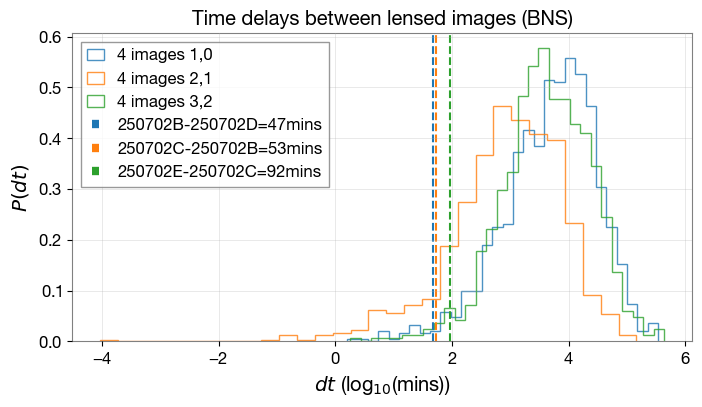

In [59]:
import numpy as np
import matplotlib.pyplot as plt
# plot histogram
plt.figure(figsize=(8, 4))
plt.hist(np.log10(dt_4images_10), bins=30, alpha=0.8, density=True, histtype='step', color='C0', label='4 images 1,0')
plt.hist(np.log10(dt_4images_21), bins=30, alpha=0.8, density=True, histtype='step', color='C1', label='4 images 2,1') 
plt.hist(np.log10(dt_4images_32), bins=30, alpha=0.8, density=True, histtype='step', color='C2', label='4 images 3,2')

plt.axvline(np.log10(dt_10/60), color='C0', linestyle='--', label='250702B-250702D=47mins')
plt.axvline(np.log10(dt_21/60), color='C1', linestyle='--', label='250702C-250702B=53mins')
plt.axvline(np.log10(dt_32/60), color='C2', linestyle='--', label='250702E-250702C=92mins')

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel(r'$dt$ (log$_{10}$(mins))')
plt.ylabel(r'$P(dt)$')
plt.title('Time delays between lensed images (BNS)')
plt.show()